In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [3]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
import numpy as np

X = np.load('/kaggle/input/unber-1k/Visual_Features/Visual_Features/X_data.npy')
y = np.load('/kaggle/input/unber-1k/Visual_Features/Visual_Features/y_data.npy')

In [5]:
X.shape

(1118, 5, 224, 224, 3)

In [6]:
y.shape

(1118,)

In [7]:
X = X.reshape(-1, 224, 224, 3)
y = np.repeat(y, 5)

In [8]:
X.shape

(5590, 224, 224, 3)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [10]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4, activation="softmax")(x)
model = Model(inputs, x)

In [11]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, 224 * 224 * 3)).reshape(-1, 224, 224, 3)
X_val = scaler.transform(X_val.reshape(-1, 224 * 224 * 3)).reshape(-1, 224, 224, 3)
X_test = scaler.transform(X_test.reshape(-1, 224 * 224 * 3)).reshape(-1, 224, 224, 3)

In [14]:
X_train.shape

(4472, 224, 224, 3)

In [15]:
X_test.shape

(559, 224, 224, 3)

In [16]:
X_val.shape

(559, 224, 224, 3)

In [17]:
model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - accuracy: 0.4058 - loss: 1.3506 - val_accuracy: 0.5617 - val_loss: 1.0271 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5104 - loss: 1.0719 - val_accuracy: 0.5993 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5330 - loss: 1.0312 - val_accuracy: 0.6172 - val_loss: 0.9609 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5650 - loss: 0.9952 - val_accuracy: 0.6100 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5847 - loss: 0.9385 - val_accuracy: 0.6243 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5919 - loss: 0.9370 - val_accuracy: 0.6279 - val_loss: 0.8989 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6024 - loss: 

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [25]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       222
           1       0.65      0.66      0.66       164
           2       0.77      0.53      0.63       111
           3       0.88      0.94      0.91        62

    accuracy                           0.71       559
   macro avg       0.75      0.73      0.73       559
weighted avg       0.72      0.71      0.71       559



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

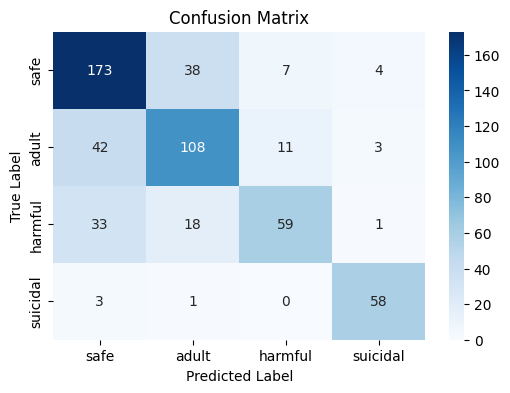

In [27]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()